In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [128]:
# exam tables we have
csv_files = os.listdir("../input")
print(">>>> WE HAVE THESE TABLES: <<<<")
print()
for csv_file in csv_files:
    if (csv_file != "HomeCredit_columns_description.csv" and csv_file != "application_test.csv"):
        print(csv_file.split(".")[0])

>>>> WE HAVE THESE TABLES: <<<<

previous_application
bureau_balance
installments_payments
application_train
sample_submission
POS_CASH_balance
credit_card_balance
bureau


In [129]:
# exam the application_train table
application_train = pd.read_csv('../input/application_train.csv')
print('Size of application_train data', application_train.shape)

Size of application_train data (307511, 122)


In [130]:
# Testing data features
app_test = pd.read_csv('../input/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [131]:
# checking missing data
total = application_train.isnull().sum().sort_values(ascending = False)
percent = (application_train.isnull().sum()/application_train.isnull().count()*100).sort_values(ascending = False)
missing_application_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_application_train_data.head(5))
print("\nsince there are no features that has a missing rate larger than 75%, we will keep all of them")

                           Total    Percent
COMMONAREA_MEDI           214865  69.872297
COMMONAREA_AVG            214865  69.872297
COMMONAREA_MODE           214865  69.872297
NONLIVINGAPARTMENTS_MODE  213514  69.432963
NONLIVINGAPARTMENTS_MEDI  213514  69.432963

since there are no features that has a missing rate larger than 75%, we will keep all of them


In [132]:
#1 Factorize binary categorical features
binary_categorical_features = ['CODE_GENDER', "FLAG_OWN_CAR", 'FLAG_OWN_REALTY']
for bin_feature in binary_categorical_features:
    application_train[bin_feature], uniques = pd.factorize(application_train[bin_feature])
    
# One-hot encoding for categorical columns with get_dummies

# Note we can handle the missing values of categorical features in this way:
# Add a new dummy feature (is_nan) to indicate it's missing
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

application_train, cat_cols = one_hot_encoder(application_train, True)
print(len(cat_cols))
print('Size of application_train data', application_train.shape)

146
Size of application_train data (307511, 255)


The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment
Size of application_train data (307511, 256)


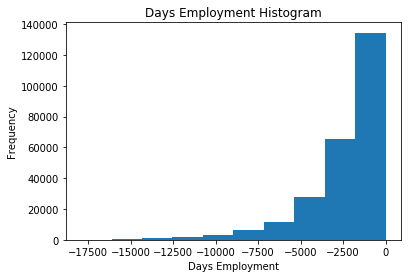

In [133]:
anom = application_train[application_train['DAYS_EMPLOYED'] == 365243]
non_anom = application_train[application_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))
# Create an anomalous flag column
application_train['DAYS_EMPLOYED_ANOM'] = application_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

application_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
plt.xlabel('Days Employment')
print('Size of application_train data', application_train.shape)

In [134]:
application_train = application_train[best_features]
# Base Line: Logistic Regression Model
from sklearn.preprocessing import MinMaxScaler, Imputer

# Drop the target from the training data
if 'TARGET' in application_train:
    train = application_train.drop(columns = ['TARGET'])
else:
    train = application_train.copy()
    
# Feature names
features = list(train.columns)

# Copy of the testing data
test = app_test.copy()

# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)

print('Training data shape: ', train.shape)

/home/wenxuan/anaconda3/envs/home-credit/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Training data shape:  (307511, 14)


In [135]:
application_train

,EXT_SOURCE_3,DAYS_BIRTH,DAYS_ID_PUBLISH,DAYS_REGISTRATION,SK_ID_CURR,DAYS_EMPLOYED,AMT_ANNUITY,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT,EXT_SOURCE_1,AMT_INCOME_TOTAL,REGION_POPULATION_RELATIVE,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START
0,0.139376,-9461,-2120,-3648.0,100002,-637.0,24700.5,-1134.0,406597.5,0.083037,202500.000,0.018801,351000.0,10
1,NaN,-16765,-291,-1186.0,100003,-1188.0,35698.5,-828.0,1293502.5,0.311267,270000.000,0.003541,1129500.0,11
2,0.729567,-19046,-2531,-4260.0,100004,-225.0,6750.0,-815.0,135000.0,NaN,67500.000,0.010032,135000.0,9
3,NaN,-19005,-2437,-9833.0,100006,-3039.0,29686.5,-617.0,312682.5,NaN,135000.000,0.008019,297000.0,17
4,NaN,-19932,-3458,-4311.0,100007,-3038.0,21865.5,-1106.0,513000.0,NaN,121500.000,0.028663,513000.0,11
5,0.621226,-16941,-477,-4970.0,100008,-1588.0,27517.5,-2536.0,490495.5,NaN,99000.000,0.035792,454500.0,16
6,0.492060,-13778,-619,-1213.0,100009,-3130.0,41301.0,-1562.0,1560726.0,0.774761,171000.000,0.035792,1395000.0,16
7,0.540654,-18850,-2379,-4597.0,100010,-449.0,42075.0,-1070.0,1530000.0,NaN,360000.000,0.003122,1530000.0,16
8,0.751724,-20099,-3514,-7427.0,100011,NaN,33826.5,0.0,1019610.0,0.587334,112500.000,0.018634,913500.0,14
9,NaN,-14469,-3992,-14437.0,100012,-2019.0,20250.0,-1673.0,405000.0,NaN,135000.000,0.019689,405000.0,8


In [136]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(train, train_labels)
print(roc_auc_score(train_labels, log_reg.predict(train)))
log_reg.score(train, train_labels)

/home/wenxuan/anaconda3/envs/home-credit/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5


0.9192711805431351

In [137]:
y_hat = log_reg.predict_proba(train)[:, 1]
print(roc_auc_score(train_labels, y_hat))

0.5760773453340516


In [112]:
# Try Random Forest
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
random_forest.fit(train, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=50, verbose=1, warm_start=False)

In [114]:
y_hat = random_forest.predict_proba(train)[:, 1]
print(roc_auc_score(train_labels, y_hat))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.5s


1.0


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.2s finished


In [126]:
best_features = feature_importances.sort_values(by="importance", ascending=False)["feature"][1:15].values
print(best_features)

['EXT_SOURCE_3' 'DAYS_BIRTH' 'DAYS_ID_PUBLISH' 'DAYS_REGISTRATION'
 'SK_ID_CURR' 'DAYS_EMPLOYED' 'AMT_ANNUITY' 'DAYS_LAST_PHONE_CHANGE'
 'AMT_CREDIT' 'EXT_SOURCE_1' 'AMT_INCOME_TOTAL'
 'REGION_POPULATION_RELATIVE' 'AMT_GOODS_PRICE' 'HOUR_APPR_PROCESS_START']


In [119]:
# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

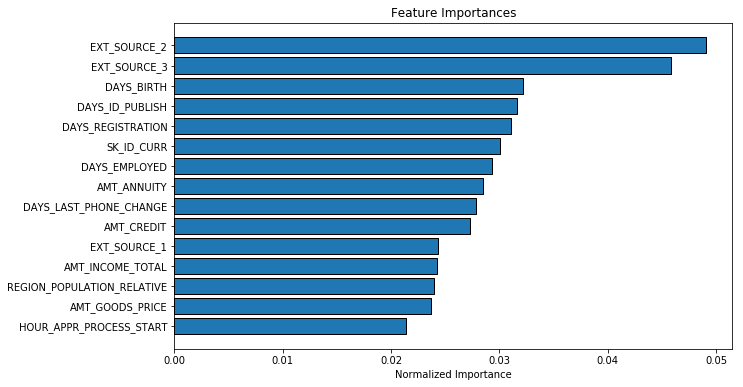

In [120]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df
# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)